In [12]:
!pip install --quiet imageio livelossplot torcheval

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import imageio.v2 as imageio
import livelossplot
import matplotlib.pyplot as plt
import pandas as pd
import torcheval.metrics

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# Define constants
IMG_SIZE = 256
BATCH_SIZE = 32
DATA_DIR = 'Data'
VALID_SPLIT = 0.2

# Define the transformations for training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Define the transformations for validation (no augmentation)
valid_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Load the datasets
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

# Calculate lengths for train/validation split
total_size = len(full_dataset)
valid_size = int(VALID_SPLIT * total_size)
train_size = total_size - valid_size

# Split the dataset
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

# Override the transform for validation dataset
valid_dataset.dataset.transform = valid_transform

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

# Print some information about the datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Class labels: {full_dataset.class_to_idx}")

# Optional: check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Number of training samples: 8000
Number of validation samples: 2000
Class labels: {'damaged': 0, 'no_damage': 1}
Using device: cpu


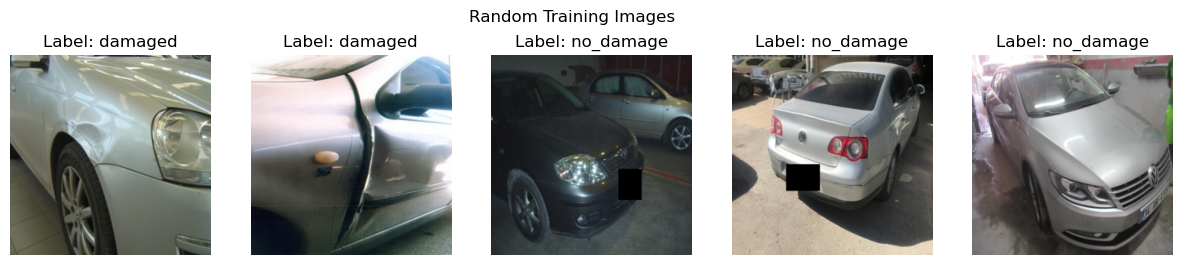

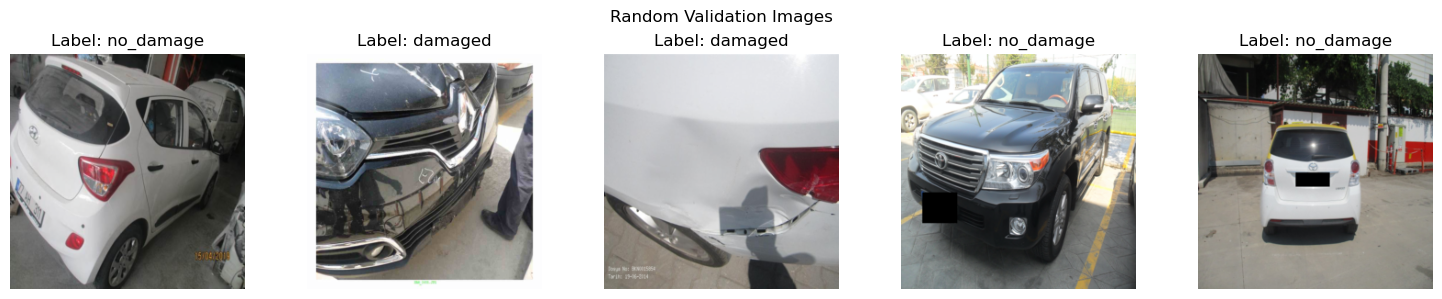

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_images(dataset, num_images=5, title=""):
    # Create a figure with num_images columns
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(title)
    
    # Get random indices
    indices = random.sample(range(len(dataset)), num_images)
    
    for idx, ax in zip(indices, axes):
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy and transpose from (C,H,W) to (H,W,C)
        image = image.numpy().transpose(1, 2, 0)
        
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        
        # Clip values to be between 0 and 1
        image = np.clip(image, 0, 1)
        
        # Plot the image
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Label: {list(full_dataset.class_to_idx.keys())[label]}')

# Show random training images
show_random_images(train_dataset, title="Random Training Images")

# Show random validation images
show_random_images(valid_dataset, title="Random Validation Images")

plt.tight_layout()
plt.show()

In [16]:
class TreeNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_0 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2, stride=1, device=device)
        self.conv_1 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, device=device)
        self.fc_3 = torch.nn.Linear(28800, 256)
        self.fc_4 = torch.nn.Linear(256, 2)


        self.bn_0 = torch.nn.BatchNorm2d(32)
        self.bn_1 = torch.nn.BatchNorm2d(64)
        self.bn_2 = torch.nn.BatchNorm2d(128)
        self.bn_3 = torch.nn.BatchNorm1d(256)

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)


        self.leakyrelu = torch.nn.LeakyReLU()
        self.dropout2d = torch.nn.Dropout2d(p=0.3)
        self.dropout = torch.nn.Dropout(p=0.3)


    def forward(self, X):

        X = self.conv_0(X)
        X = self.bn_0(X)
        X = self.leakyrelu(X)
        X = self.pool(X)
        X = self.dropout2d(X)

        X = self.conv_1(X)
        X = self.bn_1(X)
        X = self.leakyrelu(X)
        X = self.pool(X)
        X = self.dropout2d(X)


        X = self.conv_2(X)
        X = self.bn_2(X)
        X = self.leakyrelu(X)
        X = self.pool(X)
        X = self.dropout2d(X)

        X = X.reshape(X.shape[:-3] + (-1,))

        X = self.fc_3(X)
        X = self.leakyrelu(X)
        X = self.dropout(X)

        X = self.fc_4(X)

        return X

test_model = TreeNetwork()
for images, _ in train_loader:
    test_output = test_model(images[:5])
    break

/Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <408F81C0-C6C8-33EF-B02E-B683F7178A71> /Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ozgur/opt/anaconda3/lib

In [17]:
loss_function = torch.nn.CrossEntropyLoss()

In [18]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=5e-5, weight_decay = 1e-3, patience = 300, **kwargs):
    model = model_class(**kwargs)
    try:
        model = model.cuda()
    except:
        print("cuda() failed")
    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)
    best_val_loss = float('inf')
    early_stop_counter = 0

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()

        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad(set_to_none=True)
            prediction = model(batch_X)
            loss = loss_function(prediction, batch_Y)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            loss.backward()

            # Compute gradient sum for logging
            gradient_sum = 0.0
            for param in model.parameters():
                if param.grad is not None:
                    gradient_sum += torch.sum(torch.abs(param.grad)).item()

            optimizer.step()

        if (i + 1) % 10 == 0:
            liveloss_updates = {}
            with torch.no_grad():
                model.eval()

                def get_metrics(metrics_prefix, metrics_X, metrics_Y):
                    metrics_prediction = model(metrics_X)

                    return {
                        f"{metrics_prefix}loss": loss_function(metrics_prediction, metrics_Y),
                        f"{metrics_prefix}accuracy": torcheval.metrics.functional.multiclass_accuracy(torch.argmax(metrics_prediction, dim=-1), metrics_Y)
                    }
                
                liveloss_updates.update(get_metrics("", train_X, train_Y))
                liveloss_updates.update(get_metrics("val_", validation_X, validation_Y))

            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            
            liveloss_updates["gradient_sum"] = gradient_sum

            
            current_lr = optimizer.param_groups[0]['lr']
            liveloss_updates["learning rate"] = current_lr

            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

            val_loss = liveloss_updates['val_loss']
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {i+1}")
                break

        scheduler.step()

    return model

In [19]:
#tree_model = train_model(TreeNetwork, epochs=2000)

In [20]:
class EfficientTreeNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Reduce initial image size and use more efficient channel sizes
        self.features = torch.nn.Sequential(
            # First block: 256x256x3 -> 128x128x16
            torch.nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, device=device),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            # Second block: 128x128x16 -> 32x32x32
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, device=device),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            # Third block: 32x32x32 -> 16x16x64
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1, device=device),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            
            # Adaptive pooling to get fixed size regardless of input
            torch.nn.AdaptiveAvgPool2d((4, 4))
        )
        
        # Classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64 * 4 * 4, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



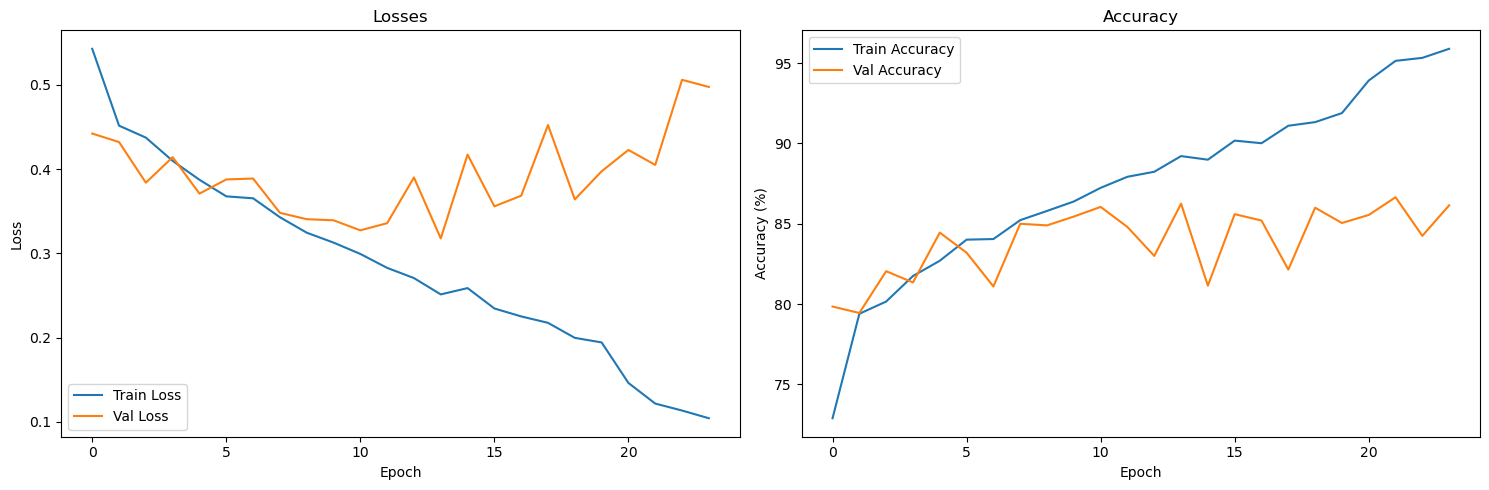

Epoch 24/50
Train Acc: 95.9% | Val Acc: 86.2%
Train Loss: 0.1042 | Val Loss: 0.4974

Early stopping at epoch 23


In [21]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import matplotlib.pyplot as plt

def quick_train_model(model_class, epochs=50, learning_rate=1e-3, **kwargs):
    model = model_class(**kwargs)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []  # Added
    val_accuracies = []    # Renamed from accuracies
    
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    def plot_progress():
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(train_losses, label='Train Loss')
        ax1.plot(val_losses, label='Val Loss')
        ax1.set_title('Losses')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # Plot accuracies
        ax2.plot(train_accuracies, label='Train Accuracy')  # Added
        ax2.plot(val_accuracies, label='Val Accuracy')
        ax2.set_title('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Acc: {train_accuracies[-1]:.1f}% | Val Acc: {val_accuracies[-1]:.1f}%')
        print(f'Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        correct = 0    # Added
        total = 0      # Added
        
        for batch_X, batch_Y in train_loader:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = loss_function(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            # Calculate training accuracy
            _, predicted = outputs.max(1)
            total += batch_Y.size(0)
            correct += predicted.eq(batch_Y).sum().item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_accuracy = 100. * correct / total
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_Y in valid_loader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                outputs = model(batch_X)
                val_loss += loss_function(outputs, batch_Y).item()
                
                _, predicted = outputs.max(1)
                total += batch_Y.size(0)
                correct += predicted.eq(batch_Y).sum().item()
        
        avg_val_loss = val_loss / len(valid_loader)
        val_accuracy = 100. * correct / total
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Plot progress every epoch
        plot_progress()
        
        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch}')
            break
    
    return model

# Train the model
efficient_model = quick_train_model(EfficientTreeNetwork)

/Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <CC4BC91F-8B6A-3F9A-B9EB-A2B9D578E202> /Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <408F81C0-C6C8-33EF-B02E-B683F7178A71> /Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/ozgur/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ozgur/opt/anaconda3/lib

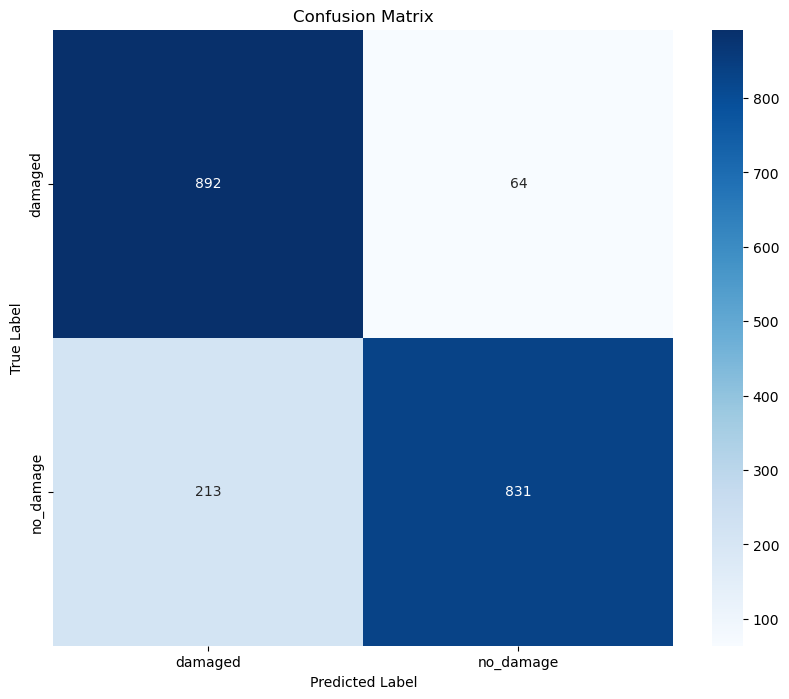


Overall Accuracy: 86.15%
damaged Accuracy: 93.31%
no_damage Accuracy: 79.60%


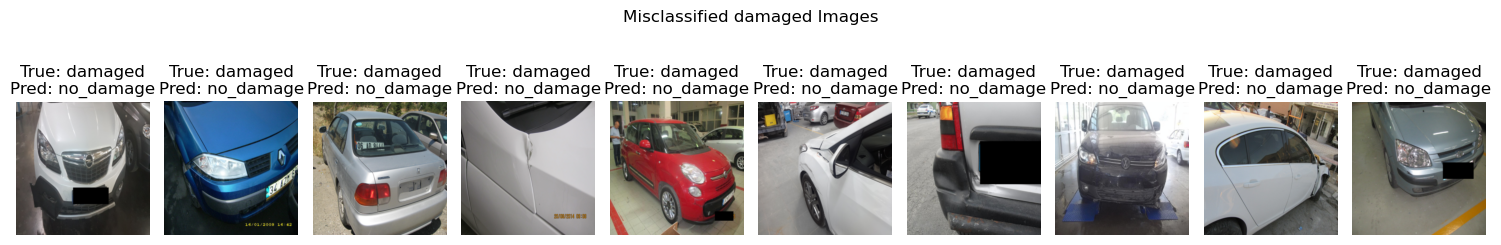

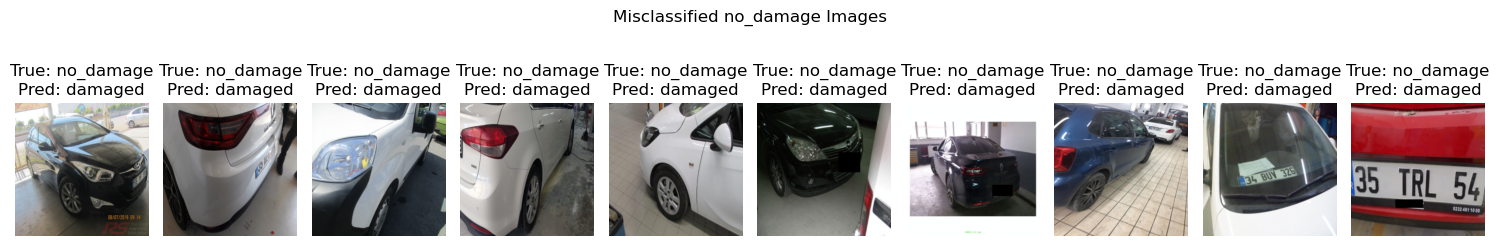

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, loader, num_misclassified=10):
    model.eval()
    all_preds = []
    all_labels = []
    misclassified_images = {0: [], 1: []}  # Store misclassified images for each class
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Store misclassified images
            misclassified_mask = (predicted != labels)
            misclassified_indices = misclassified_mask.nonzero()
            
            # Check if there are any misclassified images in this batch
            if misclassified_indices.numel() > 0:
                misclassified_indices = misclassified_indices.squeeze()
                # Handle case where only one misclassification is found
                if misclassified_indices.dim() == 0:
                    misclassified_indices = misclassified_indices.unsqueeze(0)
                
                for idx in misclassified_indices:
                    true_label = labels[idx].item()
                    if len(misclassified_images[true_label]) < num_misclassified:
                        misclassified_images[true_label].append({
                            'image': images[idx].cpu(),
                            'true': true_label,
                            'pred': predicted[idx].item()
                        })
    
    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    class_names = list(full_dataset.class_to_idx.keys())
    plt.xticks(ticks=[0.5, 1.5], labels=class_names)
    plt.yticks(ticks=[0.5, 1.5], labels=class_names)
    plt.show()
    
    # Print classification metrics
    total_samples = sum(sum(cm))
    accuracy = sum(cm[i][i] for i in range(len(cm))) / total_samples
    print(f"\nOverall Accuracy: {accuracy:.2%}")
    
    # Calculate per-class metrics
    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i][i] / sum(cm[i])
        print(f"{class_name} Accuracy: {class_accuracy:.2%}")
    
    # Plot misclassified images
    for class_idx in misclassified_images:
        if misclassified_images[class_idx]:
            plt.figure(figsize=(15, 3))
            plt.suptitle(f'Misclassified {class_names[class_idx]} Images')
            
            for i, img_data in enumerate(misclassified_images[class_idx][:num_misclassified]):
                plt.subplot(1, num_misclassified, i + 1)
                
                # Denormalize image
                img = img_data['image'].numpy().transpose(1, 2, 0)
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                plt.axis('off')
                plt.title(f'True: {class_names[img_data["true"]]}\nPred: {class_names[img_data["pred"]]}')
            
            plt.tight_layout()
            plt.show()

# Evaluate the model
evaluate_model(efficient_model, valid_loader)